# Import necessary modules
---

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

# Dataset Loading and Pre-Procesing
---

In [13]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten and normalize the images
X_train_flat = X_train.reshape(-1, 28 * 28) / 255.0
X_test_flat = X_test.reshape(-1, 28 * 28) / 255.0

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# Split data into train and validation sets
X_train_flat, X_val_flat, y_train_flat, y_val_flat = train_test_split(
    X_train_flat, y_train, test_size=0.2, random_state=42
)

# Building Neural Network from scratch
----
* Define necessary functions

In [14]:
# Initialize parameters
def init_params(input_size, hidden_size, output_size):
    w1 = np.random.randn(hidden_size, input_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((hidden_size, 1))
    w2 = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros((output_size, 1))
    return w1, b1, w2, b2


def get_predictions(X, w1, b1, w2, b2):
    z1 = np.dot(w1, X) + b1  # Assuming X is shaped (num_samples, input_dim)
    a1 = relu(z1)  # Using ReLU as in forward pass
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)  # Use softmax to get probabilities for each class
    return np.argmax(a2, axis=0)
# Function to get precision, recall, and f1 score
def calculate_precision_recall_f1(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    precisions = []
    recalls = []
    f1_scores = []
    
    # For each class, calculate precision, recall, and F1
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Macro-average (average across all classes)
    precision_macro = sum(precisions) / num_classes
    recall_macro = sum(recalls) / num_classes
    f1_macro = sum(f1_scores) / num_classes
    
    return precision_macro, recall_macro, f1_macro

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# ReLU activation function
def relu(z):
    return np.maximum(0, z)

# Derivative of ReLU
def derivative_relu(z):
    return (z > 0).astype(float)

# Softmax activation function
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# Cross-entropy loss function
def cross_entropy_loss(a2, y):
    m = y.shape[1]
    log_likelihood = -np.log(a2[y.argmax(axis=0), np.arange(m)])
    loss = np.sum(log_likelihood) / m
    return loss

# Forward pass
def forward(x, w1, b1, w2, b2):
    z1 = w1.dot(x) + b1
    a1 = relu(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

# Backpropagation
def backpropagation(z1, a1, z2, a2, w2, x, y):
    m = y.shape[1]
    dz2 = a2 - y  # No need to one-hot encode here since y is already one-hot encoded
    dw2 = (1 / m) * dz2.dot(a1.T)
    db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)
    dz1 = w2.T.dot(dz2) * derivative_relu(z1)
    dw1 = (1 / m) * dz1.dot(x.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
    return db1, dw1, db2, dw2

# Update weights and biases
def update_params(w1, b1, w2, b2, db1, dw1, db2, dw2, lr):
    w1 -= lr * dw1
    b1 -= lr * db1
    w2 -= lr * dw2
    b2 -= lr * db2
    return w1, b1, w2, b2

# Calculate accuracy
def get_accuracy(pred, y):
    return np.sum(pred == y) / y.size

# Plot learning curves
def plot_learning_curves(losses, accuracies):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

# One-hot encoding of labels
def one_hot_encode(y, num_classes):
    y_encoded = np.zeros((y.size, num_classes))
    y_encoded[np.arange(y.size), y.flatten().astype(int)] = 1  # Ensure y is integer type
    return y_encoded.T

# Gradient descent function
def grad_desc(x, y, iterations, lr):
    w1, b1, w2, b2 = init_params(x.shape[0], 128, y.shape[0])  # Assuming hidden layer size of 128
    losses = []
    accuracies = []
    
    for i in range(iterations):
        z1, a1, z2, a2 = forward(x, w1, b1, w2, b2)
        loss = cross_entropy_loss(a2, y)
        losses.append(loss)
        
        db1, dw1, db2, dw2 = backpropagation(z1, a1, z2, a2, w2, x, y)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, db1, dw1, db2, dw2, lr)
        accuracy = get_accuracy(get_predictions(x, w1, b1, w2, b2), np.argmax(y, axis=0))
        accuracies.append(accuracy)
        if i % 100 == 0:
            print(f"Iteration {i}, Accuracy {accuracy:.4f}, Loss {loss:.4f}")


    return w1, b1, w2, b2, losses, accuracies


# Data Preperation and Training
---

In [15]:

# Load and prepare MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# Ensure y is of integer type
y_train = y_train.astype(int)  # Convert to integer type
y_test = y_test.astype(int)  # Convert to integer type

# One-hot encode the labels
y_train_one_hot = one_hot_encode(y_train, 10)
y_test_one_hot = one_hot_encode(y_test, 10)

# Train the model
best_lr = 0.2
print(f"Training with learning rate: {best_lr}")

start_time = time.time()

# When calling grad_desc
w1, b1, w2, b2, losses, accuracies = grad_desc(x_train.T, y_train_one_hot, iterations=1000, lr=best_lr)

time_scratch = time.time() - start_time


Training with learning rate: 0.2
Iteration 0, Accuracy 0.3010, Loss 2.3622
Iteration 100, Accuracy 0.9006, Loss 0.3631
Iteration 200, Accuracy 0.9179, Loss 0.2965
Iteration 300, Accuracy 0.9276, Loss 0.2610
Iteration 400, Accuracy 0.9352, Loss 0.2353
Iteration 500, Accuracy 0.9412, Loss 0.2153
Iteration 600, Accuracy 0.9457, Loss 0.1987
Iteration 700, Accuracy 0.9490, Loss 0.1846
Iteration 800, Accuracy 0.9520, Loss 0.1726
Iteration 900, Accuracy 0.9550, Loss 0.1622


# Evaluating the model
---

In [16]:
# Reshape X_test_flat to be (num_samples, 784) if it's currently (784,)
import numpy as np

X_test_flat = X_test_flat.reshape(-1, 784)  # Ensure it's a 2D array

y_pred_scratch = get_predictions(X_test_flat.T, w1, b1, w2, b2)  # Shape should now be (num_samples,)
acc_scratch = np.sum(y_pred_scratch == y_test) / y_test.size

# Assuming y_test_labels is already defined and in shape (10000,)
precision_scratch, recall_scratch, f1_scratch = calculate_precision_recall_f1(y_test, y_pred_scratch, num_classes=10)
print(f'Accuracy: {acc_scratch:.4f}')
print(f'Precision: {precision_scratch:.4f}')
print(f'Recall: {recall_scratch:.4f}')
print(f'F1-Score: {f1_scratch:.4f}')
print(f"Training Time (Neural Network from Scratch): {time_scratch:.4f} seconds")


Accuracy: 0.9547
Precision: 0.9544
Recall: 0.9542
F1-Score: 0.9542
Training Time (Neural Network from Scratch): 975.6853 seconds


# Plotting the loss-accuracy curve
---

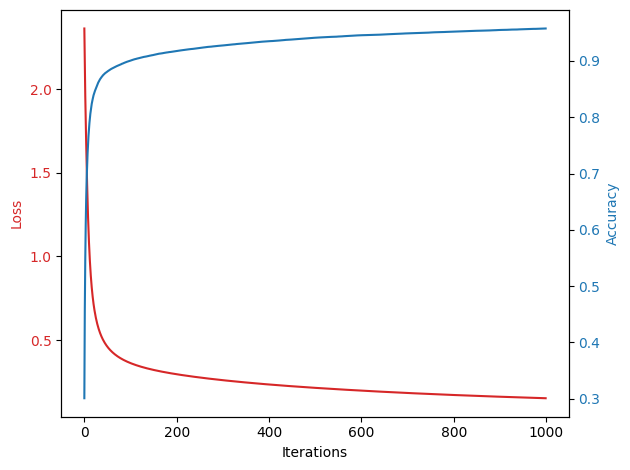

In [17]:
plot_learning_curves(losses, accuracies)

# Data Pre-Processing for Neural Network [Tensorflow]
---

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten and normalize the images
X_train_flat = X_train.reshape(-1, 28 * 28) / 255.0
X_test_flat = X_test.reshape(-1, 28 * 28) / 255.0

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# Split data into train and validation sets
X_train_flat, X_val_flat, y_train_flat, y_val_flat = train_test_split(
    X_train_flat, y_train, test_size=0.2, random_state=42
)

# Model building, Training and Evaluation
---

In [19]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(784,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the TensorFlow model and record time
start_time = time.time()

history = model.fit(X_train_flat, y_train_flat, epochs=10, batch_size=128, validation_data=(X_val_flat, y_val_flat))

time_tf = time.time() - start_time

# Evaluate TensorFlow model
y_pred_tf = model.predict(X_test_flat)

# Convert one-hot encoded y_test back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Get predicted class labels from the model output
y_pred_tf_labels = np.argmax(y_pred_tf, axis=1)

print("\nEvaluation of TensorFlow Neural Network:")
acc_tf = accuracy_score(y_test_labels, y_pred_tf_labels)
precision_tf = precision_score(y_test_labels, y_pred_tf_labels, average='weighted')
recall_tf = recall_score(y_test_labels, y_pred_tf_labels, average='weighted')
f1_tf = f1_score(y_test_labels, y_pred_tf_labels, average='weighted')

print(f'Accuracy: {acc_tf:.4f}')
print(f'Precision: {precision_tf:.4f}')
print(f'Recall: {recall_tf:.4f}')
print(f'F1-Score: {f1_tf:.4f}')
print(f"Training Time (TensorFlow): {time_tf:.4f} seconds")


c:\Users\Shikhar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8495 - loss: 0.5127 - val_accuracy: 0.9493 - val_loss: 0.1795
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9539 - loss: 0.1560 - val_accuracy: 0.9610 - val_loss: 0.1306
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9704 - loss: 0.1027 - val_accuracy: 0.9684 - val_loss: 0.1097
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9788 - loss: 0.0735 - val_accuracy: 0.9683 - val_loss: 0.1001
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9854 - loss: 0.0528 - val_accuracy: 0.9737 - val_loss: 0.0876
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9864 - loss: 0.0459 - val_accuracy: 0.9742 - val_loss: 0.0878
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9900 - loss: 0.0354 - val_accuracy: 0.9728 - val_loss: 0.0888
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9929 - loss: 0.0265 - val_accuracy: 0.

<Figure size 1200x500 with 0 Axes>

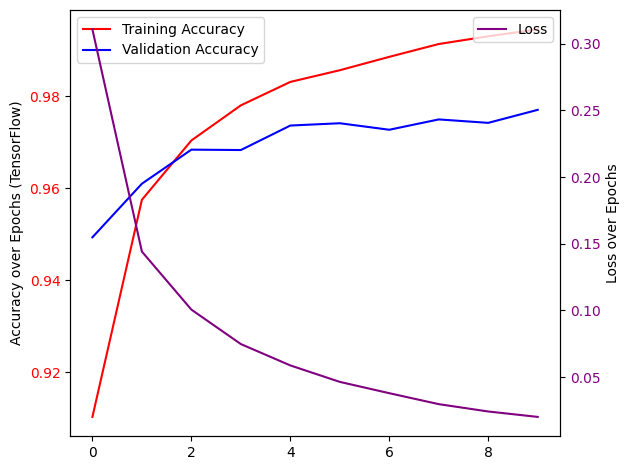

In [20]:
plt.figure(figsize=(12, 5))
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], label='Training Accuracy',color='red')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy',color='blue')
ax2.plot(history.history['loss'],label='Loss',color='purple')
ax1.set_ylabel('Accuracy over Epochs (TensorFlow)')
ax2.set_ylabel('Loss over Epochs')

ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='purple')
fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()



In [21]:
print("\nComparison of Neural Network from Scratch vs. TensorFlow:")

print(f"{'Metric':<20} {'NN from Scratch':<20} {'TensorFlow':<20}")
print(f"{'-'*60}")
print(f"{'Accuracy':<20} {acc_scratch:<20.4f} {acc_tf:<20.4f}")
print(f"{'Precision':<20} {precision_scratch:<20.4f} {precision_tf:<20.4f}")
print(f"{'Recall':<20} {recall_scratch:<20.4f} {recall_tf:<20.4f}")
print(f"{'F1-Score':<20} {f1_scratch:<20.4f} {f1_tf:<20.4f}")
print(f"{'Training Time (s)':<20} {time_scratch:<20.4f} {time_tf:<20.4f}")



Comparison of Neural Network from Scratch vs. TensorFlow:
Metric               NN from Scratch      TensorFlow          
------------------------------------------------------------
Accuracy             0.9547               0.9754              
Precision            0.9544               0.9755              
Recall               0.9542               0.9754              
F1-Score             0.9542               0.9754              
Training Time (s)    975.6853             26.2165             


In [22]:
model.save('model/mnist_model.h5')  # Saving the model
np.savez('model/mnist_nn_weights.npz', w1=w1, w2=w2, b1=b1, b2=b2)
